In [2]:
import numpy as np
import enum
import time
import matplotlib.pyplot as plt

plt.style.use("ggplot")

In [ ]:
#  Сохраняем времена работы
time_dict = {}
#  Сохраняем невязки
error_dict = {}

class Method(enum.Enum):
    '''
        Перечисление для удобного выбора метода
    '''
    GAUSS       = 1
    GAUSS_TWO   = 2
    ORTHOG      = 3
    RUN         = 4
    LU          = 5
    ITER_SIMPLE = 6
    ITER_YKOBI  = 7
    ITER_ZEIDEL = 8
    ITER_MIN_R  = 9

class Solver:
    """
        Решатель СЛАУ
    """
    def time_and_error(func):
        """
            Декоратор для замеров времени выполнения и невязки 
        """
        def wrapped(self, *args):
            start_time = time.perf_counter_ns()
            res = func(self, *args)
            end_time = time.perf_counter_ns()
            name = func.__name__
            if name not in time_dict:
                time_dict[name] = []
            if name not in error_dict:
                error_dict[name] = []
            time_dict[name].append(end_time - start_time)
            error_dict[name].append(np.linalg.norm(args[0] @ res - args[1]))
            return res
        wrapped.__name__ = func.__name__
        return wrapped

    def solve(self, A: np.array, f: np.array, method: Method=Method.GAUSS, x0=None, n=None, P=None) -> np.array:
        '''
        Решить СЛАУ

        Ключевые аргументы:
            A       - матрица системы
            vec     - вектор правых частей
            method  - метод, применяемый для вычислений(по умолчанию Method.GAUSS)
        Аргументы для итерационных методов:
            x0      - начальное приближение решения
            n       - число итераций
            P       - некоторая несингулярная матрица, нужна для простой итерации

        Типы метод: 
            Method.GAUSS        - метод Гаусса
            Method.GAUSS_TWO    - метод Гаусса с выбором главного элемента по строкам
            Method.ORTHOG       - метод ортогонализации
            Method.RUN          - метод прогонки
            Method.LU           - метод LU-разложения
            Method.ITER_SIMPLE  - метод простой итерации
            Method.ITER_YKOBI   - метод Якоби
            Method.ITER_ZEIDEL  - метод Зейделя
            Method.ITER_MIN_R   - метод минимальных невязок
        '''
        if method == Method.GAUSS:
            answer = self.GAUSS_solve(A, f)
        elif method == Method.GAUSS_TWO:
            answer = self.GAUSS_TWO(A, f)
        elif method == Method.ORTHOG:
            answer = self.orthogonalize_method(A, f)
        elif method == Method.RUN:
            answer = self.RUN(A, f)
        elif method == Method.LU:
            answer = self.LU_solve(A, f)
        elif method == Method.ITER_SIMPLE:
            answer = self.iter_simple(A, f, P, x0, n)
        elif method == Method.ITER_ZEIDEL:
            answer = self.iter_ZEIDEL(A, f, x0, n)
        elif method == Method.ITER_YKOBI:
            answer = self.iter_YKOBI(A, f, x0, n)
        elif method == Method.ITER_MIN_R:
            answer = self.iter_MIN_R(A, f, x0, n)

        #  Допустимое отклонение невязки
        # r_delta = 1e-5
        #  Проверяем невязку
        # r = np.linalg.norm(A @ answer - f)
        # if r > r_delta:
            # raise RuntimeError(f"Discrepancy {r} > {r_delta}; Dim: {A.shape[0]}")

        return answer

    @time_and_error
    def GAUSS_solve(self, A: np.array, f: np.array) -> np.array:
        """
            Решение СЛАУ методом Гаусса

            Параметры:
                A - матрица СЛАУ
                f - вектор правых частей
    
            Возвращает:
                x - решение СЛАУ
        """
        #  Расширенная матрица
        extended_A = np.append(A, f, axis=1)
        #  Прямой ход метода Гаусса
        dim = extended_A.shape[0]
        for j in np.arange(dim-1):
            extended_A[j, j:] /= extended_A[j, j]
            
            # коэфф-ты на которые умножится j-я строка
            j_column = extended_A[j+1:, j]
            j_column = j_column[..., None]
            extended_A[j+1:, j:] -= extended_A[j, j:] * j_column
            
        #  Обратный ход метода Гаусса
        extended_A[dim-1, dim-1:] /= extended_A[dim-1, dim-1]
        for j in np.arange(dim-1, 0, -1):
            j_column = extended_A[:j, j]
            j_column = j_column[..., None]
            extended_A[:j, j:] -= extended_A[j, j:] * j_column
        
        return extended_A[:, -1][..., None]

    def __LU(self,A):
        """
            LU-разложение матрицы
                        
            Параметры:
                A - матрица СЛАУ
    
            Возвращает:
                L - нижняя треугольная матрица
                U - верхняя треугольная матрица
        """
        n = A.shape[0]
        L = np.eye(n).astype(float)
        U = np.zeros_like(A).astype(float)
        for i in range(n):
            # Сначала вычисляем строку U
            for j in range(i, n):
                U[i, j] = A[i, j] - np.dot(L[i, :i], U[:i, j])

            # Затем вычисляем столбец L
            for j in range(i+1, n):
                L[j, i] = (A[j, i] - np.dot(L[j, :i], U[:i, i])) / U[i, i]

        return L, U

    @time_and_error
    def LU_solve(self, A, f):
        """
            Решение СЛАУ методом LU-разложения
                        
            Параметры:
                A - матрица СЛАУ
                f - вектор правых частей
    
            Возвращает:
                x - решение СЛАУ
        """
        # Выполняем LU-разложение матрицы A
        L, U = self.__LU(A)
        n = A.shape[0]

        # Прямая подстановка: Ly = f
        y = np.zeros(n)
        for i in np.arange(n):
            y[i] = f[i] - L[i, :i] @ y[:i]

        # Обратная подстановка: Ux = y
        x = np.zeros(n)
        for i in np.arange(n-1, -1, -1):
            x[i] = (y[i] - U[i, i+1:] @ x[i+1:]) / U[i, i]    
        
        return x[..., None]

    @time_and_error
    def GAUSS_TWO(self, A, f):
        """
            Решение СЛАУ методом Гаусса с выбором главного элемента по строкам
                        
            Параметры:
                A - матрица СЛАУ
                f - вектор правых частей
    
            Возвращает:
                x - решение СЛАУ
        """
        #  Расширенная матрица
        extended_A = np.append(A, f, axis=1).astype(float)

        dim = extended_A.shape[0]
        for i in np.arange(dim-1):
            #  Ищем индекс самого большого модулю элемента в текущем столбце
            ind_max = i + np.argmax(np.abs(extended_A[i:, i]))

            #  Меняем местами текущую строку со строкой ind_max
            extended_A[[i, ind_max]] = extended_A[[ind_max, i]]

            #  Вычисляем поправочные множители
            i_column = extended_A[i+1:, i] / extended_A[i, i]
            i_column = i_column[..., None]
            extended_A[i+1:, i:] -= extended_A[i, i:] * i_column

        #  Обратный ход метода Гаусса
        for j in np.arange(dim-1, -1, -1):
            extended_A[j, :] /= extended_A[j, j]
            j_column = extended_A[:j, j]
            j_column = j_column[..., None]
            extended_A[:j, j:] -= extended_A[j, j:] * j_column

        return extended_A[:, -1][..., None]

    def __get_c(self, A):
        """ Получаем наддиагональные элементы """
        a_mask = np.zeros_like(A)
        a_mask[:-1, 1:] = np.eye(A.shape[0]-1)
        return A[np.where(a_mask != 0)]

    def __get_b(self, A):
        """ Получаем диагональные элементы """
        tmp = A * np.eye(A.shape[0])
        b = tmp[np.where(tmp != 0)]
        return b

    def __get_a(self, A):
        """ Получаем поддиагональные элементы """
        c_mask = np.zeros_like(A)
        c_mask[1:, :-1] = np.eye(A.shape[0]-1)
        return A[np.where(c_mask != 0)]

    @time_and_error
    def RUN(self, A, f):
        """
            Решение СЛАУ методом прогонки
            
            Параметры:
                A - матрица СЛАУ
                f - вектор правых частей
    
            Возвращает:
                x - решение СЛАУ
        """
        n = A.shape[0]

        #  Получим коэфф-ты a, b, c
        a = self.__get_a(A)
        b = self.__get_b(A)
        c = self.__get_c(A)

        #  Вектор ответов
        x = np.zeros(n)
        #  Вспомогательные векторы
        B_ = np.zeros(n)
        F_ = np.zeros(n)

        #  Считаем вспомогательные векторы
        B_[0] = b[0]
        for i in range(1, n):
            B_[i] = b[i] - a[i-1] / B_[i-1] * c[i-1]

        F_[0] = f[0]
        for i in range(1, n):
            F_[i] = f[i] - a[i-1] / B_[i-1] * F_[i-1]

        #  Считаем ответ
        x[n-1] = F_[n-1] / B_[n-1]
        for i in range(n-2, -1, -1):
            x[i] = (F_[i] - c[i]*x[i+1]) / B_[i]

        return x

    def __orthogonalize_rows(self, A, f):
        """
            Ортогонализация матрицы СЛАУ
        """
        n = A.shape[0]

        # Создаем расширенную матрицу
        Af = np.column_stack((A, f)).astype(np.float64)

        # Процесс ортогонализации строк (метод Грама-Шмидта)
        for i in range(n):
            # Нормируем текущую строку
            norm = np.linalg.norm(Af[i, :n])

            Af[i] = Af[i] / norm

            # Ортогонализуем последующие строки относительно текущей
            for j in range(i + 1, n):
                projection = np.dot(Af[j, :n], Af[i, :n])
                Af[j] = Af[j] - projection * Af[i]
        return Af

    @time_and_error
    def orthogonalize_method(self, A, f):
        """
            Решение СЛАУ методом ортогонолизации

            Параметры:
                A - матрица СЛАУ
                b - вектор правых частей
    
            Возвращает:
                A_ort.T @ b_ort - решение СЛАУ
        """
        A_ort = self.__orthogonalize_rows(A, f)[:, :-1]
        f_ort = self.__orthogonalize_rows(A, f)[:, -1:]

        return A_ort.T @ f_ort
    
    @time_and_error
    def iter_simple(self, A, f, P, x0, n):
        """
            Решение СЛАУ методом простой итерации
            
            Параметры:
                A   - матрица СЛАУ
                f   - вектор правых частей
                P   - некоторая несингулярная матрица
                x0  - начальное приблиение решения
                n   - число итераций

            Возвращает:
                x - решение СЛАУ
        """
        B = (P @ A + np.eye(A.shape[0]))
        C = P @ f
        x_next = x0
        for _ in np.arange(n):
            x_prev = x_next
            x_next = B @ x_prev + C

        return x_next
    
    @time_and_error
    def iter_ZEIDEL(self, A, f, x0, n):
        """
            Решение СЛАУ методом Зейделя
            
            Параметры:
                A   - матрица СЛАУ
                f   - вектор правых частей
                x0  - начальное приблиение решения
                n   - число итераций

            Возвращает:
                x - решение СЛАУ
        """
        # Диагональная матрица
        L = np.tril(A, k=-1)  # Нижняя треугольная без  диагонали
        U = np.triu(A, k=1)   # Верхняя треугольная без диагонали
        D = np.diag(np.diag(A))
        x_next = x0
        LD_reverse = np.linalg.inv(L + D)
        for _ in np.arange(n):
            x_prev = x_next
            x_next = LD_reverse @ (f - U @ x_prev)

        return x_next

    @time_and_error
    def iter_YKOBI(self, A, f, x0, n):
        """
            Решение СЛАУ методом Якоби
            
            Параметры:
                A   - матрица СЛАУ
                f   - вектор правых частей
                x0  - начальное приблиение решения
                n   - число итераций

            Возвращает:
                x - решение СЛАУ
        """
        # Диагональная матрица
        L = np.tril(A, k=-1)  # Нижняя треугольная без диагонали
        U = np.triu(A, k=1)   # Верхняя треугольная без диагонали
        D = np.diag(np.diag(A))
        x_next = x0
        D_reverse = np.linalg.inv(D)
        for _ in np.arange(n):
            x_prev = x_next
            x_next = D_reverse @ (f - (L + U) @ x_prev)

        return x_next

    @time_and_error
    def iter_MIN_R(self, A, f, x0, n):
        """
            Решение СЛАУ методом минимальных невязок
            
            Параметры:
                A   - матрица СЛАУ
                f   - вектор правых частей
                x0  - начальное приблиение решения
                n   - число итераций

            Возвращает:
                x - решение СЛАУ
        """
        x_next = x0
        r_next = A @ x_next - f
        #  Проверка, чтоб не делить на 0
        tmp = A @ r_next
        if((np.vdot(tmp, tmp)) == 0):
            return x_next
        tau_next = (np.vdot(r_next, tmp)) / (np.vdot(tmp, tmp))

        for _ in np.arange(n):
            x_prev = x_next
            r_prev = r_next
            tau_prev = tau_next
            x_next = x_prev - tau_prev * r_prev
            r_next = A @ x_next - f
            tmp = A @ r_next
            tau_next = (np.vdot(r_next, tmp)) / (np.vdot(tmp, tmp))
            #  Проверка, чтоб не делить на 0
            if(np.vdot(tmp, tmp) == 0):
                break

        return x_next

## Генераторы рандомных матриц

In [3]:
def generate_random_system_uniform(n, low=0, high=10, seed=None):
    """
    Генерирует случайные матрицы A и b с равномерным распределением
    
    Параметры:
    n - размерность системы
    low - нижняя граница случайных чисел
    high - верхняя граница случайных чисел
    seed - seed для генератора случайных чисел
    """
    if seed is not None:
        np.random.seed(seed)
    
    a = np.random.uniform(low, high, size=(n, n)).astype(np.float64)
    b = np.random.uniform(low * 2, high * 2, size=(n, 1)).astype(np.float64)
    
    return a, b


def generate_tridiagonal_system(n, seed=5, min_val=-10, max_val=10):
    """
    Генерирует случайную трехдиагональную систему уравнений
    
    Параметры:
        n - размер системы (количество уравнений)
        min_val, max_val - диапазон случайных значений
        seed - для np.random.uniform
    
    Возвращает:
        f - вектор правой части (размер n)
        A_full - полная матрица системы (n x n) для проверки
    """
    
    # Инициализация диагоналей
    a = np.zeros(n)
    b = np.zeros(n)
    c = np.zeros(n)
    f = np.zeros(n)

    np.random.seed(seed)
    # Заполнение диагоналей случайными значениями
    for i in range(n):
        b[i] = np.random.uniform(min_val, max_val)
        
        # Верхняя диагональ
        if i < n-1:
            c[i] = np.random.uniform(min_val, max_val)
        
        # Нижняя диагональ
        if i > 0:
            a[i] = np.random.uniform(min_val, max_val)
        
        # Правая часть
        f[i] = np.random.uniform(min_val, max_val)
    
    # Создаем полную матрицу
    A_full = np.zeros((n, n))
    for i in range(n):
        if i > 0:
            A_full[i, i-1] = a[i]  # нижняя диагональ
        A_full[i, i] = b[i]         # главная диагональ
        if i < n-1:
            A_full[i, i+1] = c[i]   # верхняя диагональ
    
    return A_full, f

In [10]:
def generate_spd_system(n, cond_number=100, random_state=None):
    """
    Генерирует СЛАУ с симметричной положительно определенной матрицей A и вектором f.
    
    Параметры:
    ----------
    n : int
        Размерность системы
    cond_number : float, optional
        Желаемое число обусловленности матрицы (по умолчанию 100)
    random_state : int, optional
        Seed для генератора случайных чисел для воспроизводимости
    
    Возвращает:
    -----------
    A : ndarray, shape (n, n)
        Симметричная положительно определенная матрица
    f : ndarray, shape (n,)
        Вектор правой части
    x_true : ndarray, shape (n,)
        Истинное решение (для проверки)
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    # Генерируем случайную ортогональную матрицу Q
    # Используем QR-разложение случайной матрицы
    Q, _ = np.linalg.qr(np.random.randn(n, n))
    
    # Генерируем собственные значения с заданным числом обусловленности
    # Собственные значения равномерно распределены в логарифмической шкале
    # между 1/cond_number и 1
    eigenvals = np.logspace(np.log10(1/cond_number), 0, n)
    
    # Создаем диагональную матрицу с этими собственными значениями
    D = np.diag(eigenvals)
    
    # Строим симметричную положительно определенную матрицу A = Q D Q^T
    A = Q @ D @ Q.T
    
    # Генерируем случайное истинное решение
    x_true = np.random.randn(n)
    
    # Вычисляем правую часть f = A x_true
    f = A @ x_true
    
    return A, f, x_true


## Демонстрация работы кода с итерационными методами

In [30]:
part1 = np.arange(5, 5001, 500)  # от 5 до 5000 с шагом 500

# Создаем массив от 5000 до 10000 с шагом 1000
part2 = np.arange(5000, 10001, 1000)  # от 5000 до 10000 с шагом 1000

# Объединяем массивы и убираем возможные дубликаты
dim_array = np.unique(np.concatenate((part1, part2)))

#  Подчищаем прошлые замеры
time_dict.clear()
error_dict.clear()
sl = Solver()
for n in dim_array:
    print(f"Current n: {n}")
    #  Генерируем СЛАУ
    A, f, x_true = generate_spd_system(n)
    #  Начальное приближение
    x0 = x_true - 0.01

    sl.solve(A, f, Method.ITER_ZEIDEL, x0, 5)
    sl.solve(A, f, Method.ITER_MIN_R, x0, 5)
    sl.solve(A, f, Method.ITER_YKOBI, x0, 5)
    sl.solve(A, f, Method.ITER_SIMPLE, x0, 5, -0.25 * np.eye(A.shape[0]))


Current n: 5
Current n: 505
Current n: 1005
Current n: 1505
Current n: 2005
Current n: 2505
Current n: 3005
Current n: 3505
Current n: 4005
Current n: 4505
Current n: 5000
Current n: 6000
Current n: 7000
Current n: 8000
Current n: 9000
Current n: 10000


## Графики для времени и невязки в логорифмичесиком масштабе

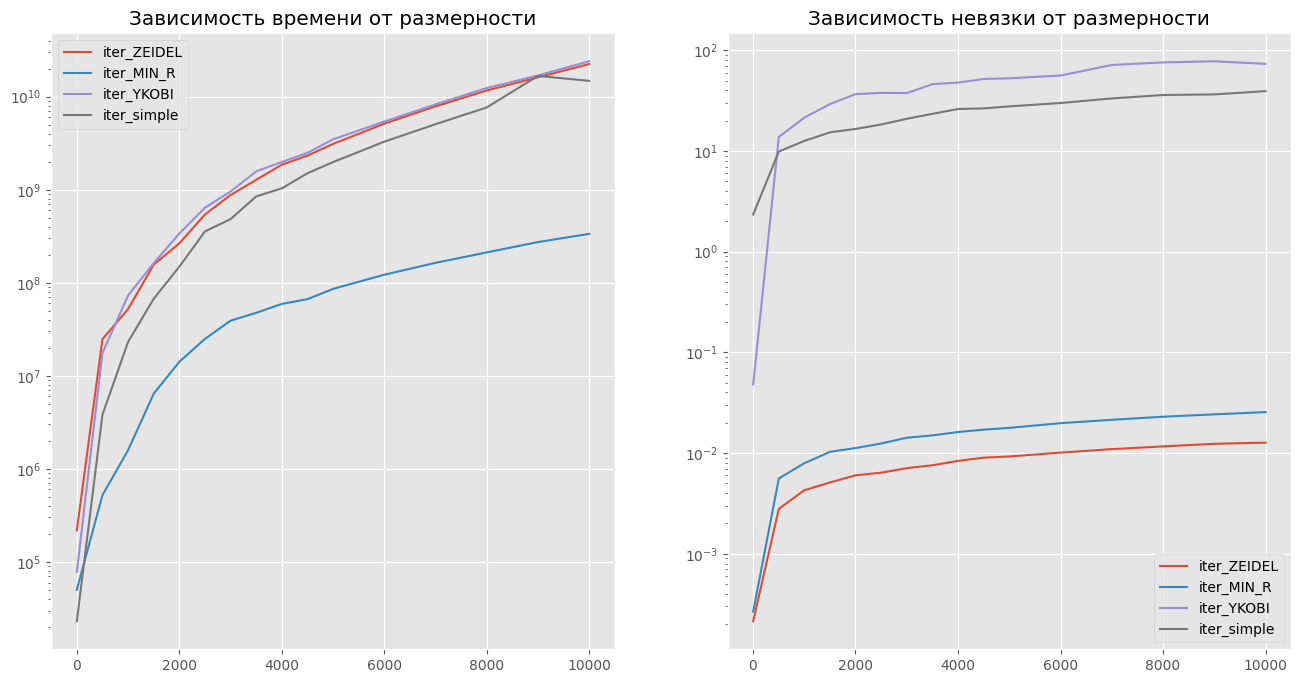

In [37]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
#  Строим графики для времени и невязки
dim_array = np.unique(np.concatenate((part1, part2)))
for name in time_dict.keys():
    axes[0].plot(dim_array, time_dict[name], label=name)
    axes[0].set_title("Зависимость времени от размерности")
    axes[0].set_yscale('log')
    axes[0].legend(loc=0)

    axes[1].plot(dim_array, error_dict[name], label=name)
    axes[1].set_title("Зависимость невязки от размерности")
    axes[1].set_yscale('log')
    axes[1].legend(loc=0)


### Как видно, методы простой итерации и Якоби сильно расходятся. Это в принципе ожидаемо, т.к. у нас есть достаточное условие сходимости только для метода Зейделя. Проверять сходимости для Якоби и простой итерации заранее через критерий я не стал

## Демонстрация работы кода с прямыми методами

### Извиняюсь, что с прямыми методами только до размеров 8000. Даже это у меня считалось 4 часа и больше я не дотерпел

In [5]:
sl = Solver()
part1 = np.arange(5, 5001, 500)  # от 5 до 5000 с шагом 500

# Создаем массив от 5000 до 10000 с шагом 1000
part2 = np.arange(5000, 10001, 1000)  # от 5000 до 10000 с шагом 1000

# Объединяем массивы и убираем возможные дубликаты
dim_array = np.unique(np.concatenate((part1, part2)))
#  Подчищаем прошлые замеры
time_dict.clear()
error_dict.clear()

for n in dim_array:
    A, f = generate_random_system_uniform(n, seed=5)
    sl.solve(A, f)
    sl.solve(A, f, Method.GAUSS_TWO)
    sl.solve(A, f, Method.LU)
    sl.solve(A, f, Method.ORTHOG)

    A, f = generate_tridiagonal_system(n, seed=5)
    sl.solve(A, f, Method.RUN)


C:\Users\User\AppData\Local\Temp\ipykernel_9320\783602209.py:152: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[i] = f[i] - L[i, :i] @ y[:i]


KeyboardInterrupt: 

## Графики для времени и невязки в логорифмичесиком масштабе

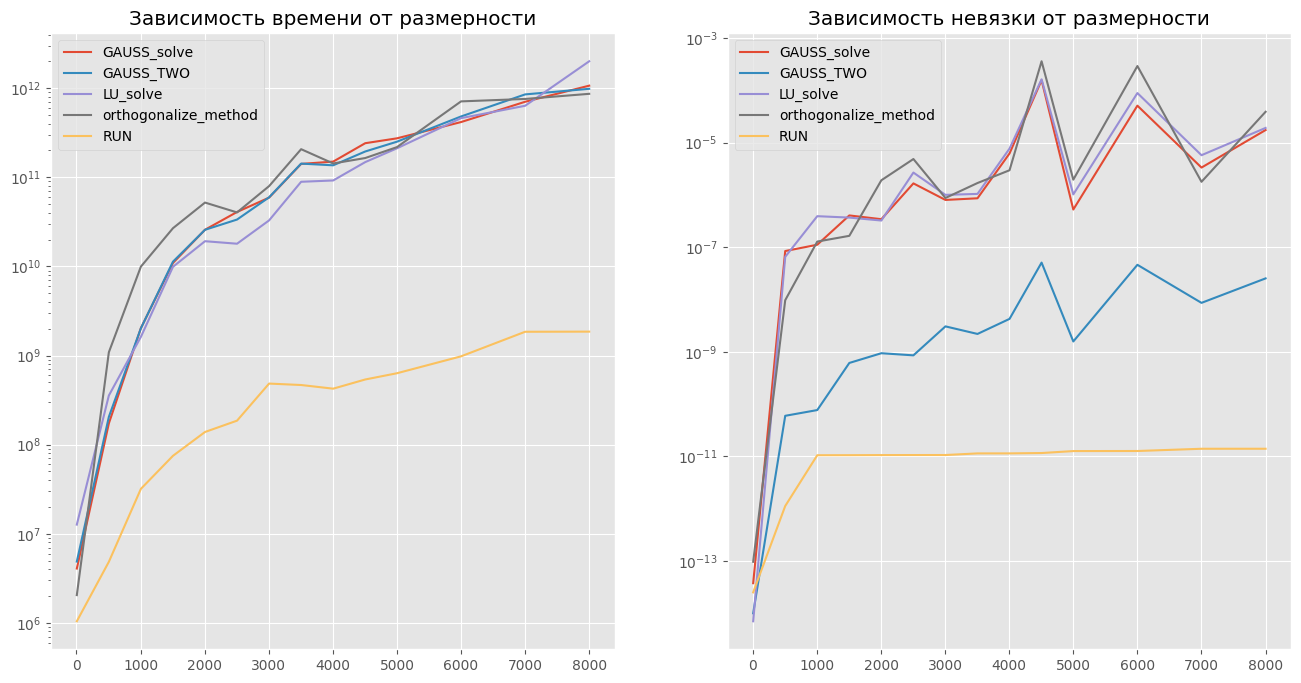

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
#  Строим графики для времени и невязки
dim_array = dim_array[:14]
for name in time_dict.keys():
    axes[0].plot(dim_array, time_dict[name][:14], label=name)
    axes[0].set_title("Зависимость времени от размерности")
    axes[0].set_yscale('log')
    axes[0].legend(loc=0)

    axes[1].plot(dim_array, error_dict[name][:14], label=name)
    axes[1].set_title("Зависимость невязки от размерности")
    axes[1].set_yscale('log')
    axes[1].legend(loc=0)
